<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - SVM
    <br>
<font color=black size=4>
    Alireza Gargoori Motlagh, Alireza Heidari
    
<br><br>
<font size=4>
   **Name**: Arshia Dadras<br>
   **Student ID**: 99109109<br> <br>
In this homework, we are going to implement the algorithms from the second and third chapters of the course, so reading the notebooks of these chapters would be quite useful. Also, we are going to evaulate and compare our models by the metrics defined in chapter 3. Keep in mind to complete all of the following questions and write your own codes in the TODO parts.

## <font face="Times New Roman" size=4><div dir=ltr>
## Problem 3: Face Classification by SVM on Eigenfaces (150 points)
In the following problem, we are going to build a classifier to distinguish the faces of 40 people on a toy dataset. The dataset includes 400 pictures of 40 people faces, each by a 64*64 pixel picture. Use the following cell to download the dataset:

In [1]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

faces = datasets.fetch_olivetti_faces()
print(faces.data.shape)
print(faces.images[0].shape)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 4096)
(64, 64)


<font face="Times New Roman" size=4><div dir=ltr>
### Visualization of the Faces (5 points)
Plot an image of each class in one figure using subplots. (Note that the design matrix X is availabe in <code>faces.data</code> and the target values available in <code>faces.target</code> .)

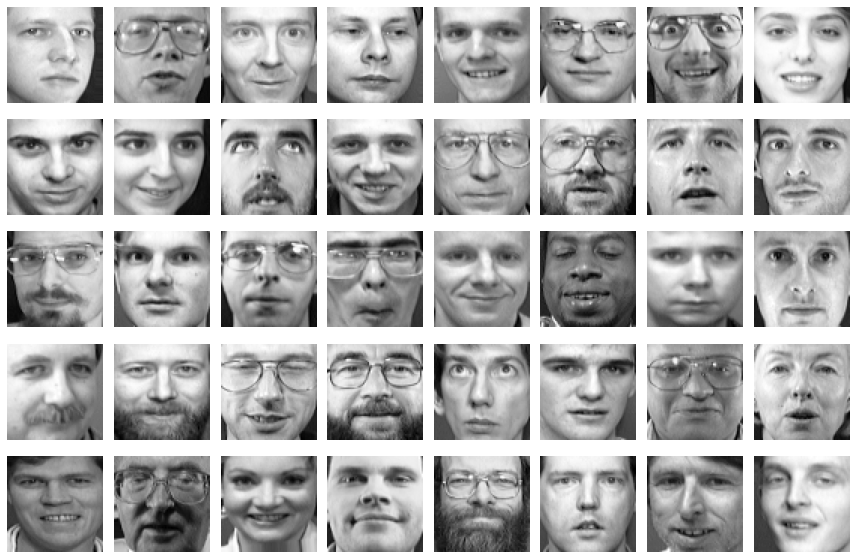

In [2]:
plt.figure(figsize=(12,8))
for id in range(40):
    index = np.random.choice(np.arange(0, faces.target.shape[0])[faces.target == id])
    plt.subplot(5, 8, id + 1)

    plt.imshow(faces.images[index], cmap='gray')
    plt.axis('off')
plt.tight_layout()

<font face="Times New Roman" size=4><div dir=ltr>
### Train-Test Split (2 points)
Split the data into train and test sets and print the dimensions of each set. (70% for train and 30% for test)

In [3]:
def train_test_split(X, y, train_size=0.7):
    indexes = np.arange(0, X.shape[0])
    np.random.shuffle(indexes)

    id = int(train_size * X.shape[0])
    train, test = indexes[:id], indexes[id:]

    return X[train], y[train], X[test], y[test]

In [4]:
X_train, y_train, X_test, y_test = train_test_split(faces.data, faces.target)

<font face="Times New Roman" size=4><div dir=ltr>
### Dimensionality Reduction (18 points)
As you might have guessed, the number of featuers, i.e. pixels, is quite large and training a classifier might take a considerbale time. However, using a wise method to reduce the dimension of our data could decrease the cost of training the model. In the following cell use PCA (Principal Component Analysis) to reduce the dimension of the dataset. Choose an appropirate number of components in your PCA and explain your reason for your choice.

In [5]:
class PCA():
    def fit(self, X, dim=None, mean=True):
        self.dim = dim if dim else X.shape[1]
        self.mean = np.mean(X, axis=0) if mean else 0

        cov_matrix = np.cov(X - self.mean, rowvar=False)
        eigen_values, eigen_vectors = np.linalg.eigh(cov_matrix)

        eigen_vectors = eigen_vectors.T
        sorted_components = np.argsort(eigen_values)[::-1]

        self.projection_matrix = eigen_vectors[sorted_components]
        self.explained_variance = eigen_values[sorted_components]
        self.explained_variance_ratio = self.explained_variance / eigen_values.sum()

    def transform(self, X):
        return np.dot(X - self.mean, self.projection_matrix[:self.dim].T)

    def inv_transform(self, X):
        return np.dot(X, self.projection_matrix[:self.dim]) + self.mean

In [6]:
pca = PCA()
pca.fit(X_train)

<font face="Times New Roman" size=4><div dir=ltr>
Plot the scree plot of the proportion of the variance explained(PVE) vs principal components to determine the number of principal components for futher analysis.

In [7]:
cum_sum_exp = np.cumsum(pca.explained_variance_ratio)
dim = np.argmax(cum_sum_exp >= 0.95) + 1
pca.dim = dim

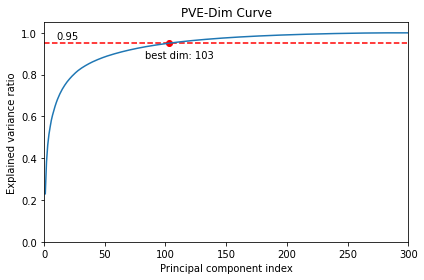

In [8]:
plt.text(10, 0.97, '0.95')
plt.plot([0.95] * 300, 'r--')
plt.text(dim - 20, 0.88, f'best dim: {dim}')
plt.plot(dim, cum_sum_exp[dim - 1], 'ro')
plt.plot(range(1, 301), cum_sum_exp[:300])

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.ylim([0, 1.05])
plt.xlim([0, 300])
plt.title('PVE-Dim Curve')
plt.tight_layout()

<font face="Times New Roman" size=4><div dir=ltr>
### Eigenfaces: Principal Components Visualization (25 points)
Plot the mean face using your PCA model with <code>pca.mean_</code> attribute followed by a reshape to original dimensions. What is this mean vector?

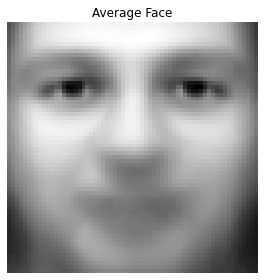

In [9]:
plt.imshow(pca.mean.reshape(faces.images[0].shape), cmap='gray')
plt.title('Average Face')
plt.axis('off')
plt.tight_layout()

<font face="Times New Roman" size=4><div dir=ltr>
Eigenfaces is the name given to a set of eigenvectors when used in the computer vision problem of human face recognition. Plot the 30 first eigenfaces sorted by their rank from the most important to the lowest. Can you explain what these faces indicate?

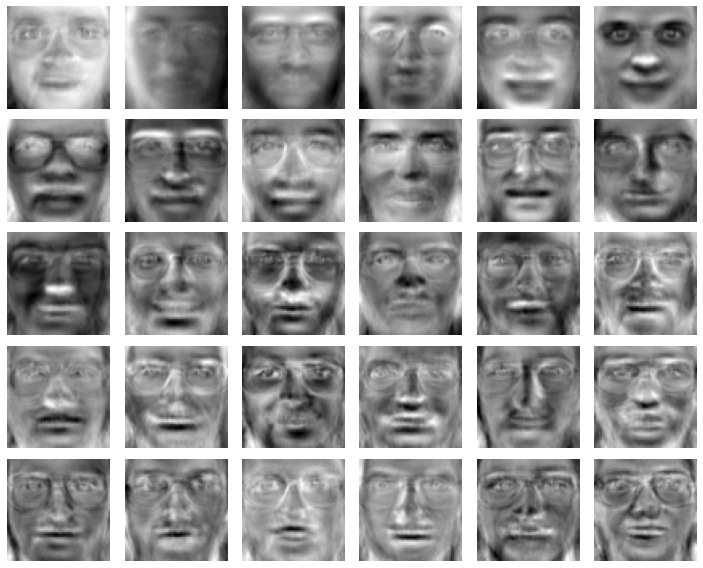

In [10]:
plt.figure(figsize=(10,8))
for id in range(30):
    plt.subplot(5, 6, id + 1)
    plt.imshow(pca.projection_matrix[id].reshape(faces.images[0].shape), cmap='gray')
    plt.axis('off')
plt.tight_layout()

<font face="Times New Roman" size=4><div dir=ltr>
Transform your train and test sets to the new feature space using your PCA module. 

In [11]:
X_train_std, X_test_std = pca.transform(X_train), pca.transform(X_test)

<font face="Times New Roman" size=4><div dir=ltr>
### Training your SVM Classifier (50 points)
Train an SVM classifier on the transformed dataset in the new feature space. You should use Grid Search Cross Validation or other validation techniques to obtain the best hyperparameters for your classifier. 

In [12]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

grid = GridSearchCV(svm.SVC(), param_grid)
grid.fit(X_train_std, y_train)
print(grid.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


SVC(C=0.1, kernel='linear')


<font face="Times New Roman" size=4><div dir=ltr>
After training your model, we can check its prediction on test samples. Run the following cell to check your model predictions with the target values on test samples. Predictions with red label indicate false classification of your model.

In [13]:
y_pred = grid.predict(X_test_std)

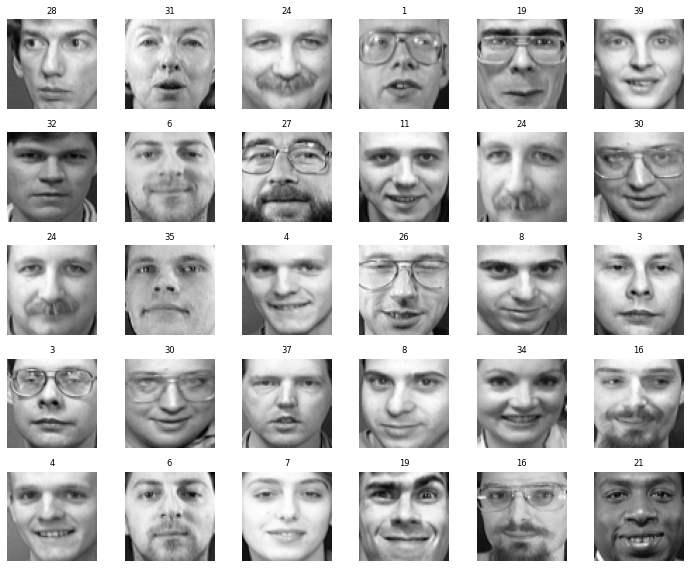

In [14]:
plt.figure(figsize=(10,8))
for i in range(30):
    plt.subplot(5, 6, i + 1)

    plt.imshow(X_test[i].reshape(faces.images[0].shape), cmap='gray')
    color = ('black' if y_pred[i] == y_test[i] else 'red')
    plt.title(y_pred[i], fontsize='small', color=color)
    plt.axis('off')
plt.tight_layout()

<font face="Times New Roman" size=4><div dir=ltr>
## Performance Measures
Let's evaluate your classifier to find out how good your model is.
    
    
### Precision Recall Tradeoff (20 points)
Plot the precision and recall versus the decision threshold figure and precision vs recall figure.

In [15]:
from sklearn.preprocessing import label_binarize

def binarize(y, classes=range(40)):
    return label_binarize(y, classes=classes)

In [16]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_pred, num_classes=40):
    precision, recall = dict(), dict()
    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true, y_pred, pos_label=i)

    y_true_ravel, y_pred_ravel = binarize(y_true).ravel(), binarize(y_pred).ravel()
    precision['micro'], recall['micro'], _ = precision_recall_curve(y_true_ravel, y_pred_ravel)

    plt.plot([0, 1], [1, 0], linestyle='--')
    plt.plot(recall['micro'], precision['micro'], alpha=0.25, color='b')
    plt.fill_between(recall['micro'], precision['micro'], alpha=0.25, color='b')

    plt.title('Precision-Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.ylim([0, 1.05])
    plt.xlim([0, 1.02])
    plt.tight_layout()
    plt.show()

    return precision, recall

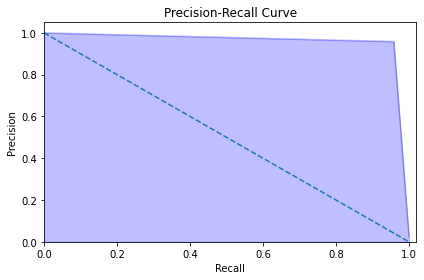

In [17]:
precision, recall = plot_precision_recall_curve(y_test, y_pred)

<font face="Times New Roman" size=4><div dir=ltr>
Then find the decision threshold, where the recall is equal to the precision. Write down it in the below cell:
    <br>
note: it should be apparent in the above figures.

decision_threshold = 0.95

recall at the above threshold = 0.95

<font face="Times New Roman" size=4><div dir=ltr>
### ROC/AUC (10 points)
Train a RandomForestClassifier with 30 estimators then plot a ROC curve, and calculate AUC for both randomForsetClassifier and your SVM classifier that you trained earlier, which one is the best by considering AUC indicator?


In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(30)
clf.fit(X_train_std, y_train)

RandomForestClassifier(n_estimators=30)

In [19]:
y_pred_2 = clf.predict(X_test_std)

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
#TODO: plot roc_curve and print roc_auc_score for svm and random forest classifiers

def plot_roc_curve(y_true, y_pred, num_classes=40):
    fpr, tpr = dict(), dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_pred, pos_label=i)

    y_true_ravel, y_pred_ravel = binarize(y_true).ravel(), binarize(y_pred).ravel()
    fpr['micro'], tpr['micro'], _ = roc_curve(y_true_ravel, y_pred_ravel)

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr['micro'], tpr['micro'], alpha=0.25, color='b')
    plt.fill_between(fpr['micro'], tpr['micro'], alpha=0.25, color='b')

    plt.title('Receiver-Operating-Characteristic Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.ylim([0, 1.05])
    plt.xlim([0.01, 1])
    plt.tight_layout()
    plt.show()

    return fpr, tpr

def roc_auc(y_true, y_pred):
    y_true_ravel, y_pred_ravel = binarize(y_true).ravel(), binarize(y_pred).ravel()
    return roc_auc_score(y_true_ravel, y_pred_ravel, average='micro')

ROC-AUC Score: 0.8803418803418803


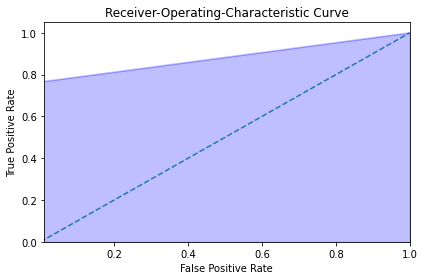

In [21]:
print(f"ROC-AUC Score: {roc_auc(y_test, y_pred_2)}")
fpr, tpr = plot_roc_curve(y_test, y_pred_2)

ROC-AUC Score: 0.9786324786324787


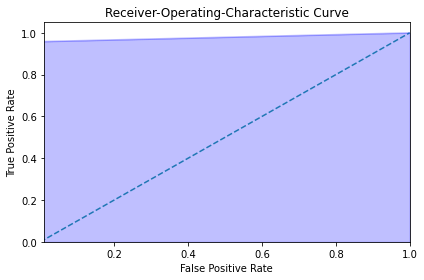

In [22]:
print(f"ROC-AUC Score: {roc_auc(y_test, y_pred)}")
fpr, tpr = plot_roc_curve(y_test, y_pred)

<font face="Times New Roman" size=4><div dir=ltr>
### Classification Report (5 points)
Use the <code>classification_report</code> to describe the performance of your SVM model with different metrics. Explain your results and compare the predictions of model on different classes in few sentences.

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       1.00      0.83      0.91         6
           5       0.67      1.00      0.80         2
           6       1.00      0.83      0.91         6
           7       0.50      0.50      0.50         2
           8       1.00      1.00      1.00         2
           9       1.00      0.67      0.80         3
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       0.75      1.00      0.86         3
          17       1.00    

<font face="Times New Roman" size=4><div dir=ltr>
### Confusion Matrix (15 points)
Plot the confusion matrix of the classifier's predictions.
Let’s focus on the errors of the plot. Divide each value in the confusion matrix by the number of images in the corresponding class so that you can compare error rates instead of absolute number of errors, then plot the result.

In [24]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

[[4 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 1 0 4]]


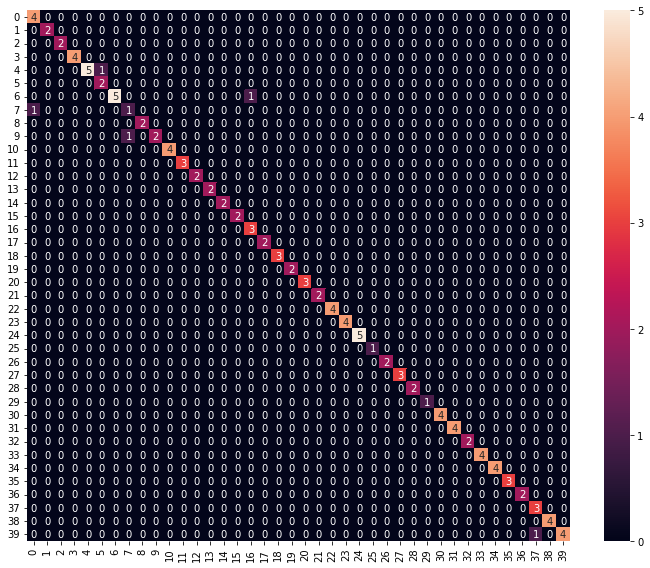

In [25]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(conf_mx, annot=True, fmt='d')
plt.tight_layout()

In [26]:
norm_conf_mx = confusion_matrix(y_test, y_pred, normalize='true')
print(norm_conf_mx)

[[1.  0.  0.  ... 0.  0.  0. ]
 [0.  1.  0.  ... 0.  0.  0. ]
 [0.  0.  1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.  0. ]
 [0.  0.  0.  ... 0.  1.  0. ]
 [0.  0.  0.  ... 0.2 0.  0.8]]


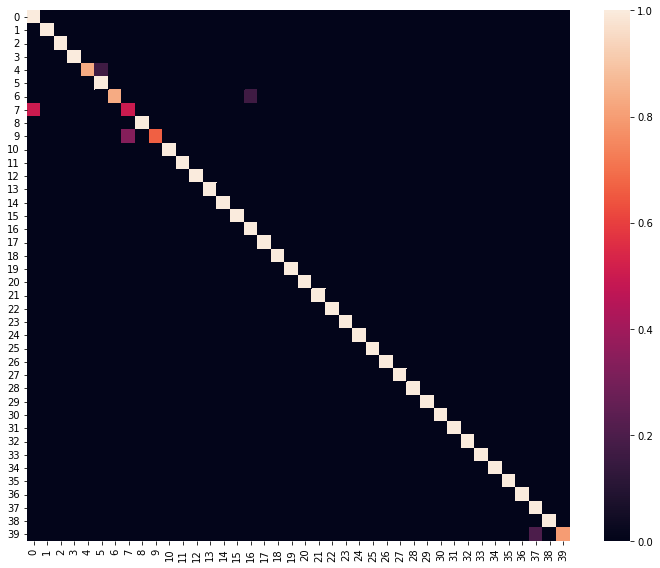

In [27]:
plt.figure(figsize=(10,8))
sns.heatmap(norm_conf_mx)
plt.tight_layout()